# Plot 1950-2008 change scaled to a change per 50 years, for every model ensemble (supp figure) and for the multi-model mean (fig 1b) - remapped to depth

In [1]:
import sys
sys.path.append('/home/ysilvy/Density_bining/Yona_analysis/programs/')
import os, glob
from netCDF4 import Dataset as open_ncfile
import matplotlib.pyplot as plt
from maps_matplot_lib import defVarmme, zon_2Dz, custom_div_cmap, modelagree, zonal_2D
from lib_remapping import remaptoz
from functions import remaptoz_xr
import numpy as np
import datetime
import pickle
import xarray as xr
from functions import lag_linregress_3D
from scipy.interpolate import griddata
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Read every run and compute trend

In [3]:
# == Read models ==
from modelsDef import defModels

models = defModels()

indir_histrcp85 = '/home/ysilvy/Density_bining/Yona_analysis/data/hist_rcp85/'
time = np.arange(1950,2101)

# Choose where to end time series
y2 = 2008 
trend_models = [0]*11
vart_models = [0]*11
model_names = ['']*11
bowl_models = [0]*11
imod=0

for i, model in enumerate(models):
#i=2; model=models[i]
    # Read hist+rcp85 files
    listruns = sorted(glob.glob(indir_histrcp85 + 'cmip5.' + model['name'] + '.' + '*zon2D.nc'))
    listruns1d = sorted(glob.glob(indir_histrcp85 + 'cmip5.' + model['name'] + '.' + '*zon1D.nc'))
    nruns = len(listruns)
    if nruns != 0:
        print('Working on', model['name'])
        # Index of common time interval
        tstart = model['props'][2]
        tend = model['props'][3] #2005
        # Loop over number of runs
        for k in range(nruns):
            namefile = os.path.basename(listruns[k])
            run_nb = namefile.split('.')[3]
            print('    . run number', k, run_nb)

            fhrcp = xr.open_dataset(listruns[k],decode_times=False)
            varkt = fhrcp.isonso.isel(time=slice(tstart+89,tend+95)) #1950-2100
            varkt['time'] = time
            varkt = varkt.sel(time=slice(1950,y2))
            fhrcp1d = xr.open_dataset(listruns1d[k],decode_times=False)
            bowlk = fhrcp1d.ptopsigma.isel(time=slice(tstart+89,tend+95))
            bowlk['time'] = time
            bowlk = bowlk.sel(time=slice(y2-10,y2)).mean(dim='time')

            # Compute trend at each grid point
            covk,cork,slopek,interceptk,pvalk,stderrk = lag_linregress_3D(x=varkt.time,y=varkt)
            trendk = slopek*50 #len(varkt.time) 
            
            # Add dimension to stack members
            trendk['members'] = run_nb
            trendk = trendk.expand_dims('members') 
            varkt['members'] = run_nb
            varkt = varkt.expand_dims('members') 
            bowlk['members'] = run_nb
            bowlk = bowlk.expand_dims('members') 
            if k==0:
                trend_mod = trendk
                bowl_mod = bowlk
                vart_mod = varkt
            else:
                trend_mod = xr.concat([trend_mod,trendk],dim='members')
                bowl_mod = xr.concat([bowl_mod,bowlk],dim='members')
                vart_mod = xr.concat([vart_mod,varkt],dim='members')
            
        trend_models[imod] = trend_mod
        model_names[imod] = model['name']
        bowl_models[imod] = bowl_mod
        vart_models[imod] = vart_mod
        imod=imod+1
        

Working on CanESM2
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
    . run number 3 r4i1p1
    . run number 4 r5i1p1
Working on CCSM4
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
    . run number 3 r4i1p1
    . run number 4 r5i1p1
    . run number 5 r6i1p1
Working on CESM1-CAM5
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
Working on CSIRO-Mk3-6-0
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
    . run number 3 r4i1p1
    . run number 4 r5i1p1
    . run number 5 r6i1p1
    . run number 6 r7i1p1
    . run number 7 r8i1p1
    . run number 8 r9i1p1
Working on FGOALS-g2
    . run number 0 r1i1p1
Working on GISS-E2-R
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r2i1p3
Working on HadGEM2-ES
    . run number 0 r1i1p1
    . run number 1 r3i1p1
Working on IPSL-CM5A-LR
    . run number 0 r2i1p1
    . run number 1 r3i1p1
    . run number 2 r4i1

## Compute ensemble means

In [4]:
# Dimensions
basin = trend_models[0].basin; basinN = len(basin)
lat = trend_models[0].latitude; latN = len(lat)
lev = trend_models[0].lev; levN = len(lev)
time = vart_models[0].time; timeN = len(time)
# Initialize xarrays
trend_means = xr.DataArray(np.zeros((len(trend_models),basinN,levN,latN)),dims=['models','basin','lev','latitude'],
                             coords=[model_names,basin,lev,lat])
bowl_means = xr.DataArray(np.zeros((len(trend_models),basinN,latN)),dims=['models','basin','latitude'],
                             coords=[model_names,basin,lat])
vart_means = xr.DataArray(np.zeros((len(trend_models),timeN,basinN,levN,latN)),dims=['models','time','basin','lev','latitude'],
                             coords=[model_names,time,basin,lev,lat])
# Loop on models to compute ensemble means
for i in range(len(trend_models)):
    trend_means[i,:,:,:] = trend_models[i].mean(dim='members')
    bowl_means[i,:,:] = bowl_models[i].mean(dim='members')
    vart_means[i,:,:,:,:] = vart_models[i].mean(dim='members')

## Compute multi-model means

In [5]:
trend_mmm = trend_means.mean(dim='models') # mmm of trends
bowl_mmm = bowl_means.mean(dim='models')
vart_mmm = vart_means.mean(dim='models') # mmm of temporal data
# Compute trend of mmm of temporal data
covmmm,cormmm,slopemmm,interceptmmm,pvalmmm,stderrmmm = lag_linregress_3D(x=vart_mmm.time,y=vart_mmm)
vart_mmm_trend = slopemmm*50

## Define model agreement from sign of trends

In [6]:
sign = xr.ufuncs.sign(trend_means)
signpos = xr.DataArray(np.count_nonzero(sign==1,axis=0),dims=['basin','lev','latitude'],coords=[basin,lev,lat]).astype(float)
signneg = xr.DataArray(np.count_nonzero(sign==-1,axis=0),dims=['basin','lev','latitude'],coords=[basin,lev,lat]).astype(float)
model_agree = xr.ufuncs.maximum(signpos,signneg)/11#(signpos+signneg)

In [7]:
model_agree=model_agree.where(np.isnan(trend_mmm)==False)

In [8]:
# -- Define variable properties
varname = defVarmme('salinity'); v = 'S'
var = varname['var_zonal_w/bowl']

minmax = varname['minmax_zonal']
clevsm = varname['clevsm_zonal']
clevsm_bold = varname['clevsm_bold']
legVar = varname['legVar']
unit = varname['unit']

# -- Show isopycnals
show_isopyc = True

# -- Density domain
rhomin = 21
rhomid = 26
rhomax = 28
domrho = [rhomin, rhomid, rhomax]

# -- Now mask points in the bowl
for ilat in range(latN):
    if np.isnan(bowl_mmm[1,ilat]) == False :
        inda = np.ma.nonzero(bowl_mmm[1,ilat]>=lev)[0]
        trend_mmm[1,inda,ilat] = np.nan
        trend_means[:,1,inda,ilat] = np.nan
        vart_mmm_trend[1,inda,ilat] = np.nan
        model_agree[1,inda,ilat] = np.nan
    if np.isnan(bowl_mmm[2,ilat]) == False :
        indp = np.ma.nonzero(bowl_mmm[2,ilat]>=lev)[0]
        trend_mmm[2,indp,ilat] = np.nan
        trend_means[:,2,indp,ilat] = np.nan
        vart_mmm_trend[2,indp,ilat] = np.nan
        model_agree[2,indp,ilat] = np.nan
    if np.isnan(bowl_mmm[3,ilat]) == False :
        indi = np.ma.nonzero(bowl_mmm[3,ilat]>=lev)[0]
        trend_mmm[3,indi,ilat] = np.nan
        trend_means[:,3,indi,ilat] = np.nan
        vart_mmm_trend[3,indi,ilat] = np.nan
        model_agree[3,indi,ilat] = np.nan

## Plot mmm in density 

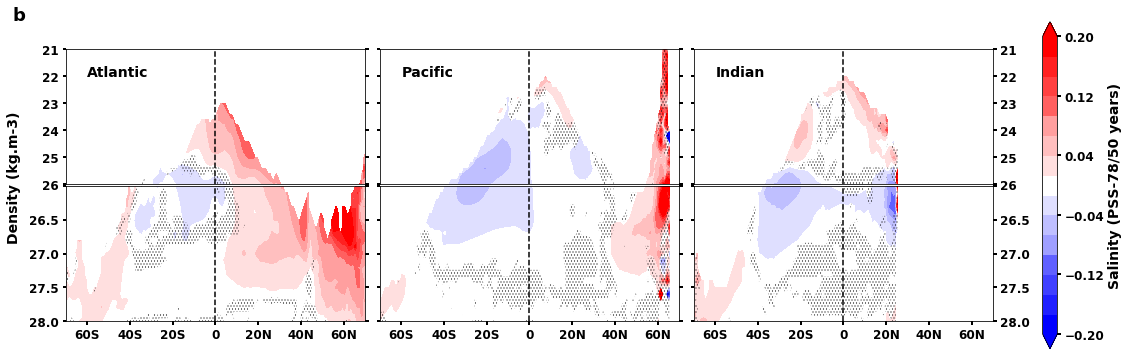

In [10]:
# ===== Create variable bundles =====
varPac = {'name': 'Pacific', 'var_change': trend_mmm.sel(basin=2), 'var_mean': None,
          'bowl1': bowl_mmm[2,:], 'bowl2': bowl_mmm[2,:], 'labBowl': None}
varAtl = {'name': 'Atlantic', 'var_change': trend_mmm.sel(basin=1), 'var_mean': None, 
          'bowl1': bowl_mmm[1,:], 'bowl2': bowl_mmm[1,:], 'labBowl': None}
varInd = {'name': 'Indian', 'var_change': trend_mmm.sel(basin=3), 'var_mean': None, 
          'bowl1': bowl_mmm[3,:], 'bowl2': bowl_mmm[3,:], 'labBowl': None}

# ===== Plot =====
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17,5))

levels = np.linspace(minmax[0], minmax[1], minmax[2])
cmap = custom_div_cmap() # plt.get_cmap('bwr')

agreelev = 0.6

cnplot = zonal_2D(plt, 'total_mme', axes[0, 0], axes[1, 0], 'left', lat, lev, varAtl, domrho, cmap, levels, clevsm, clevsm_bold)

cnplot = zonal_2D(plt, 'total_mme', axes[0, 1], axes[1, 1], 'mid', lat, lev, varPac, domrho, cmap, levels, clevsm, clevsm_bold)

cnplot = zonal_2D(plt, 'total_mme', axes[0, 2], axes[1, 2], 'right', lat, lev, varInd, domrho, cmap, levels, clevsm, clevsm_bold)

lat2d, lev2d = np.meshgrid(lat, lev)
for i in range(3):
    # -- draw stipples where models don't agree
    axes[0,i].contourf(lat2d, lev2d, model_agree.sel(basin=i+1), levels=[0, agreelev], hatches=['....'], colors='None')
    axes[1,i].contourf(lat2d, lev2d, model_agree.sel(basin=i+1), levels=[0, agreelev], hatches=['....'], colors='None')
    
for ax in axes.ravel().tolist():
    ax.tick_params(axis='both', which='major', labelsize=12)
    
plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.05, right=0.86)

cb = plt.colorbar(cnplot[0], ax=axes.ravel().tolist(), ticks=levels[::3], fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s (%s/50 years)' % (legVar, unit), fontweight='bold',fontsize=14)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontweight='bold')
cb.ax.yaxis.set_tick_params(which='major',width=2, labelsize=12)

name = 'MMM'
plotTitle = 'MMM 1950-2008 trend per 50 years'
plotName = 'suppfig1b'

plt.figtext(.006,.96,'b',fontweight='bold',fontsize=18)
# plt.suptitle(plotTitle, fontweight='bold', fontsize=14, verticalalignment='top')
plt.figtext(.002,.35,'Density (kg.m-3)',rotation='vertical',horizontalalignment='left',fontweight='bold',fontsize=14)

plt.savefig(plotName+'.png', bbox_inches='tight',dpi=150)

## Remap to z 

In [10]:
# trend_means_ma = np.ma.asarray(trend_means.data)
# trend_means_ma=np.ma.masked_where(trend_means_ma,np.isnan(trend_means)==True) #np.isnan(trend_means)==True

In [11]:
# trend_mmm_ma = np.ma.asarray(trend_mmm.data)
# trend_mmm_ma=np.ma.masked_where(trend_mmm_ma,np.isnan(trend_mmm)==True) #np.isnan(trend_means)==True

In [9]:
# == Read reference pseudo-depth used for remapping ==
indir_z = '/home/ysilvy/Density_bining/Yona_analysis/data/remaptoz/'
file_z = 'EN4.pseudo_depth.zonal.pkl'
pseudo_depth = pickle.load( open( indir_z+file_z, "rb" ))

# Repeat density into (basin,density,latitude) to remap isopycnal surfaces
lat2d,density2d = np.meshgrid(lat,lev)
density3d = np.repeat(density2d[np.newaxis,:,:],4,axis=0)

# == Target grid for remapping ==
# WOA13 grid
targetz = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
   85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
   400, 425, 450, 475, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950,
   1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
   1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2100, 2200, 2300,
   2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
   3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700,
   4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500]

# == Remap ==
# trend_mmm_z = remaptoz(trend_mmm,pseudo_depth,targetz)
density_z = remaptoz(density3d,pseudo_depth,targetz)
model_agree_z = remaptoz(model_agree,pseudo_depth,targetz)


In [10]:
def remaptoz_xr(fieldr,depthr,targetz):

    basinN = fieldr.shape[0]
    densityN = fieldr.shape[1]
    latN = fieldr.shape[2]

    fieldz = xr.DataArray(np.zeros((basinN,len(targetz),latN)),dims=['basin','pseudo-depth','latitude'],
                          coords=[fieldr.basin,targetz,fieldr.latitude])
    zbowl = np.zeros((basinN,latN))
#     zbowl = xr.DataArray(np.zeros((basinN,latN)),dims=['basin','latitude'],
#                           coords=[fiedlr.basin,fiedlr.latitude])

    for ibasin in range(basinN):
        for ilat in range(latN):

            zsig = depthr[ibasin,:,ilat] # Read pseudo-depth (function of sigma) of water column
            field_sig = fieldr[ibasin,:,ilat] # Read field values of the water column

            field_sort = field_sig[~np.isnan(field_sig)] # Remove nans
#             zsort = zsig[np.where(np.isnan(field_sig)==False)]
            zsort = zsig[~np.isnan(field_sig)]

            if len(zsort) > 1:
                zroll = np.roll(zsort,1)
                zmean=(zsort+zroll)/2
                zmean[0] = zsort[0]/2
                fieldz[ibasin,:,ilat] = griddata(zmean,field_sort,targetz) # Grid field with target pressure grid at correct z levels
                # Convert bowl density to pseudo-depth = first non-nan element
                zbowl[ibasin,ilat] = zmean[0]
            else:
                fieldz[ibasin,:,ilat] = np.nan
                zbowl[ibasin,ilat] = np.nan

    zbowl = xr.DataArray(zbowl,dims=['basin','latitude'],
                          coords=[fieldr.basin,fieldr.latitude])
    return fieldz, zbowl


In [11]:
trend_mmm_z, zbowl = remaptoz_xr(trend_mmm,pseudo_depth,targetz)
# density_z, zbowl = remaptoz_xr(density3d_xr,pseudo_depth,targetz)

## Fig 1b 

In [12]:
density_z = xr.DataArray(density_z,dims=['basin','pseudo-depth','latitude'],
                          coords=[trend_mmm.basin,targetz,trend_mmm.latitude])
density_z = density_z.where(xr.DataArray(targetz,dims=['pseudo-depth'],coords=[targetz])>=zbowl)

In [17]:
density_z.shape

(4, 102, 180)

In [18]:
zbowl.shape

(4, 180)

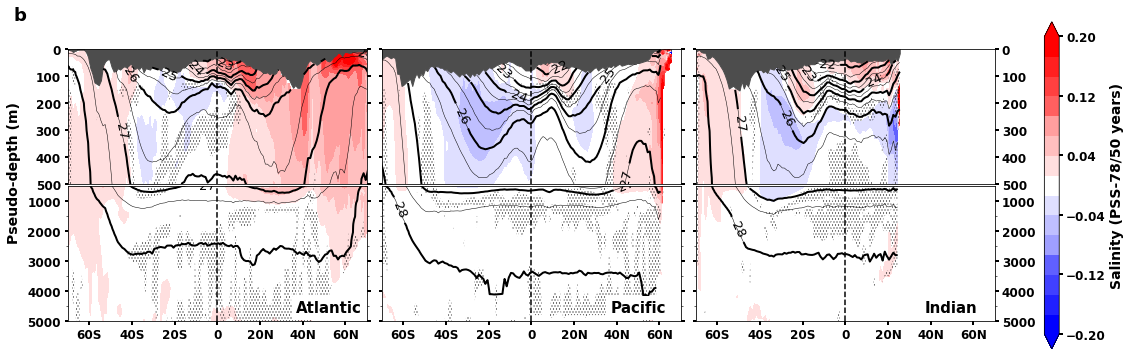

In [13]:
# -- Make variable bundles for each basin
varAtl = {'name': 'Atlantic', 'var_change': trend_mmm_z[1,:,:], 'bowl1': None, 'bowl2': None,
          'labBowl': None, 'density':density_z[1,:,:]}
varPac = {'name': 'Pacific', 'var_change': trend_mmm_z[2,:,:], 'bowl1': None, 'bowl2': None,
          'labBowl': None, 'density':density_z[2,:,:]}
varInd = {'name': 'Indian', 'var_change': trend_mmm_z[3,:,:], 'bowl1': None, 'bowl2': None,
          'labBowl': None, 'density':density_z[3,:,:]}

domzed = [0,500,5000]

# -- Create figure and axes instances
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

# -- color map
cmap = custom_div_cmap()

# -- levels
levels = np.linspace(minmax[0],minmax[1],minmax[2])

ext_cmap = 'both'
contourDict = {'cmap':cmap, 'levels':levels, 'levels2':levels, 'ext_cmap':ext_cmap, 'isopyc':show_isopyc}

# -- Contourf of signal
cnplot = zon_2Dz(plt, axes[0,0], axes[1,0], 'left', lat, targetz, varAtl,
                 contourDict, domzed)
cnplot = zon_2Dz(plt, axes[0,1], axes[1,1], 'mid', lat, targetz, varPac,
                 contourDict, domzed)
cnplot = zon_2Dz(plt, axes[0,2], axes[1,2], 'right', lat, targetz, varInd,
                 contourDict, domzed)

agreelev=0.6
lat2d, z2d = np.meshgrid(lat, targetz)
for i in range(3):
    # -- draw stipples where models don't agree
    axes[0,i].contourf(lat2d, z2d, model_agree_z[i+1,:,:], levels=[0, agreelev], hatches=['....'], colors='None')
    axes[1,i].contourf(lat2d, z2d, model_agree_z[i+1,:,:], levels=[0, agreelev], hatches=['....'], colors='None')
    # -- Draw bowl
    axes[0,i].fill_between(lat,y1=0,y2=zbowl[i+1],color='0.3')
    
plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.05, right=0.86)

for ax in axes.ravel().tolist():
    ax.tick_params(axis='both', which='major', labelsize=12)
    # Set background color
    #ax.patch.set_facecolor('#ababab')
#     ax.patch.set_alpha(0.5)
    
# -- Add colorbar
cb = plt.colorbar(cnplot[0], ax=axes.ravel().tolist(), ticks=levels[::3], fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s (%s/50 years)' % (legVar, unit), fontweight='bold',fontsize=14)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontweight='bold')
cb.ax.yaxis.set_tick_params(which='major',width=2,labelsize=12)

plt.figtext(.006,.96,'b',fontweight='bold',fontsize=18)
plt.figtext(.0005,.35,'Pseudo-depth (m)',rotation='vertical',fontweight='bold',fontsize=14)

plotTitle = 'MMM 1950-2008 trend per 50 years'
# axes[0,1].set_title(plotTitle, y=1.25, fontweight='bold', fontsize=15, verticalalignment='top')

plt.savefig('fig1b.png', bbox_inches='tight',dpi=300) 

## Plot each model's trend 

In [14]:
import string
letters = string.ascii_lowercase

CanESM2
CCSM4
CESM1-CAM5
CSIRO-Mk3-6-0
FGOALS-g2
GISS-E2-R
HadGEM2-ES
IPSL-CM5A-LR
IPSL-CM5A-MR
MIROC-ESM-CHEM
MIROC-ESM


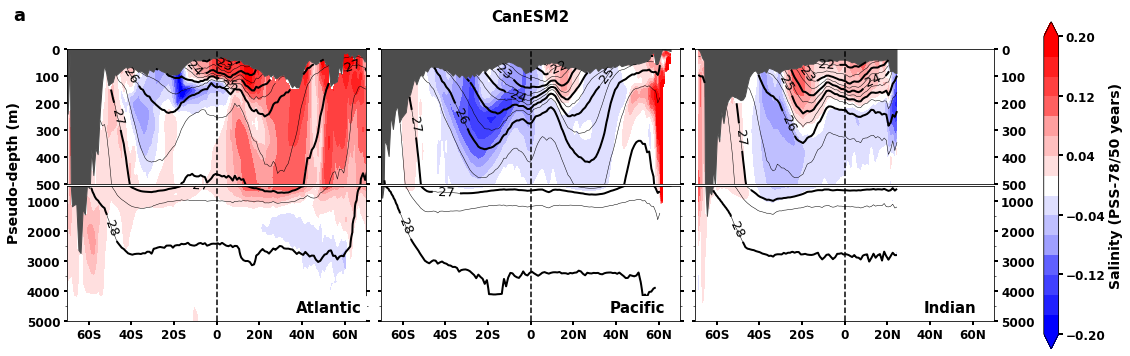

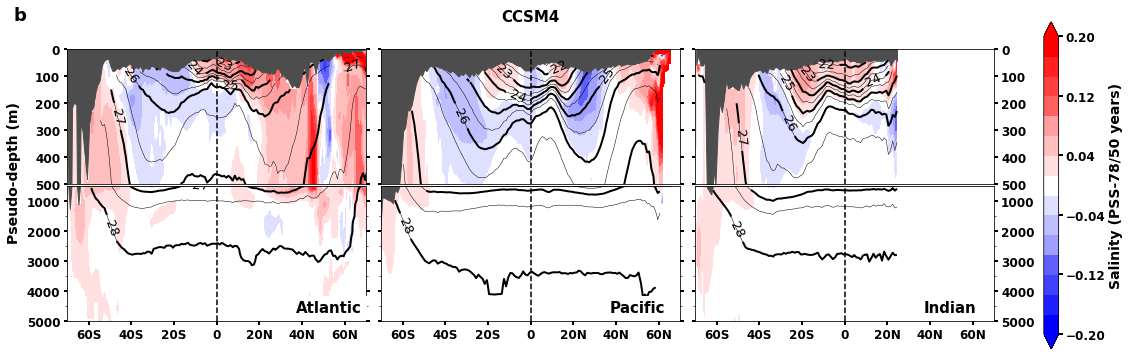

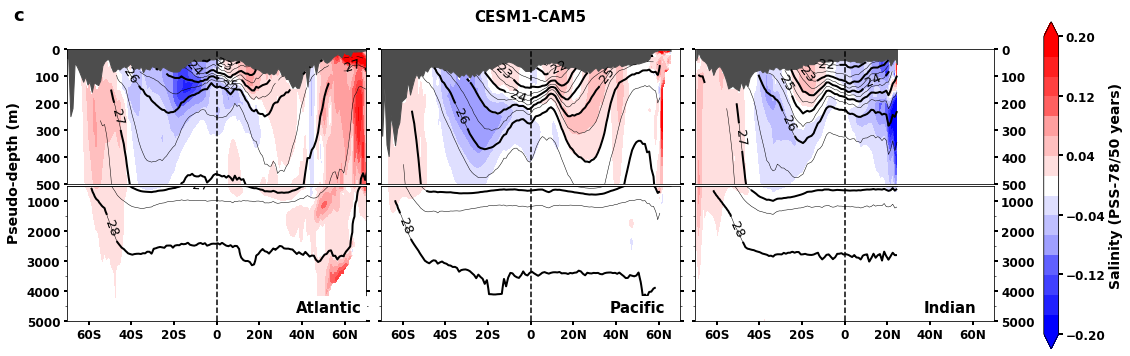

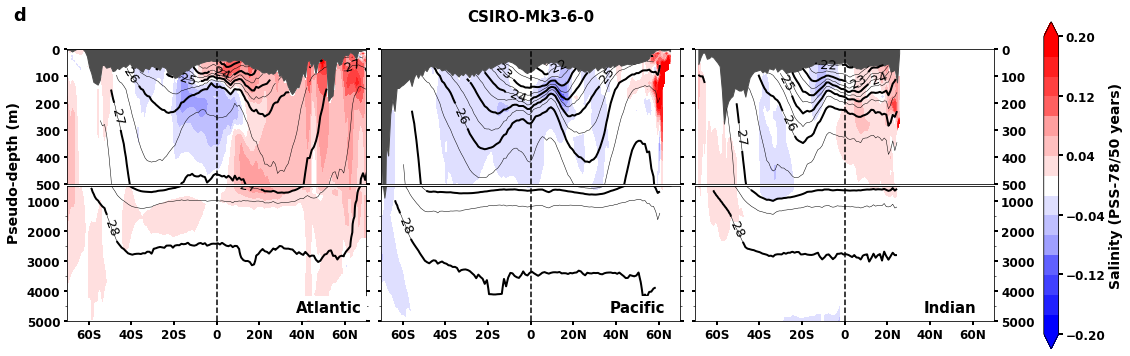

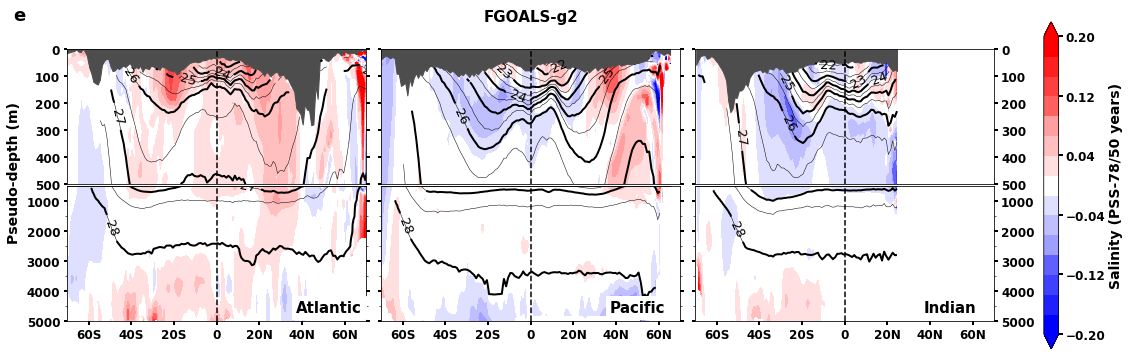

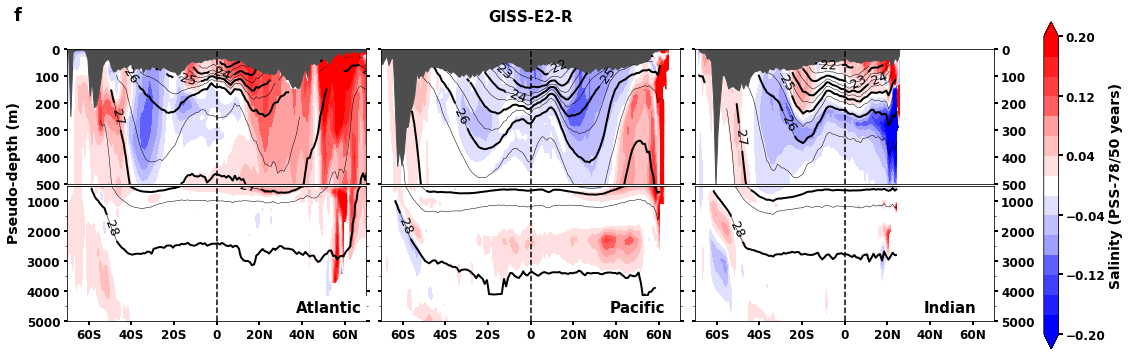

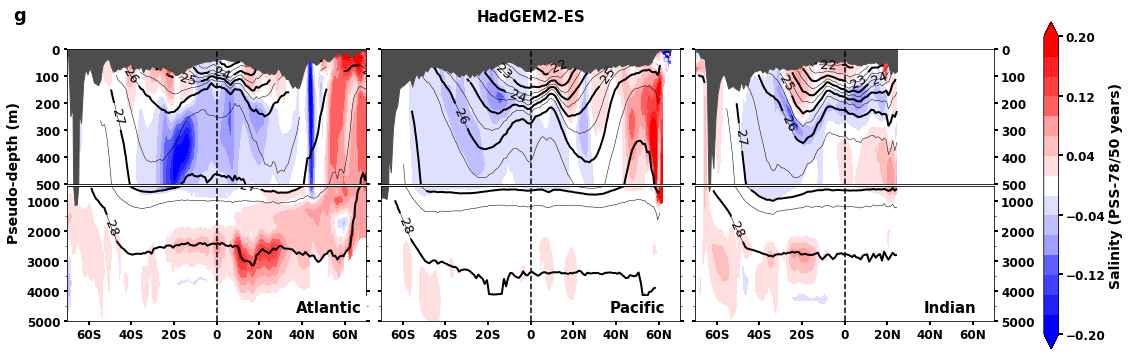

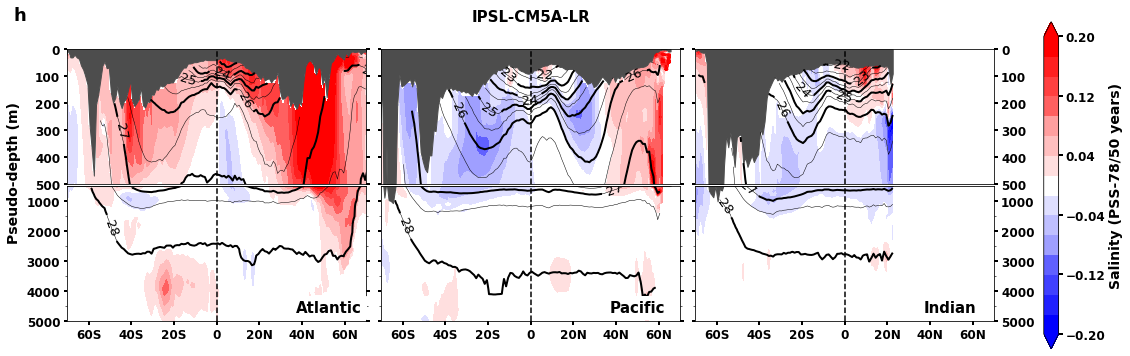

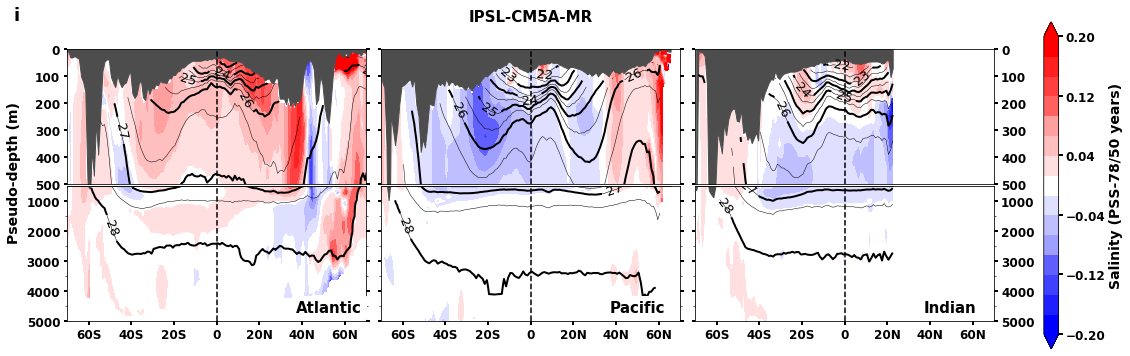

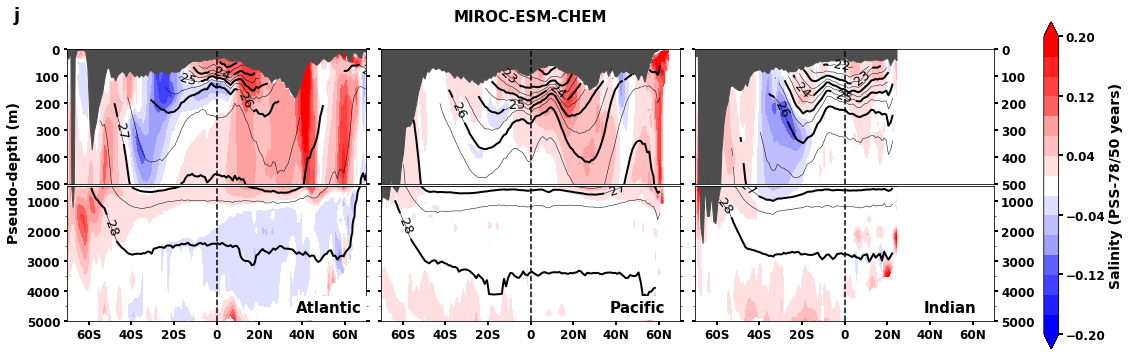

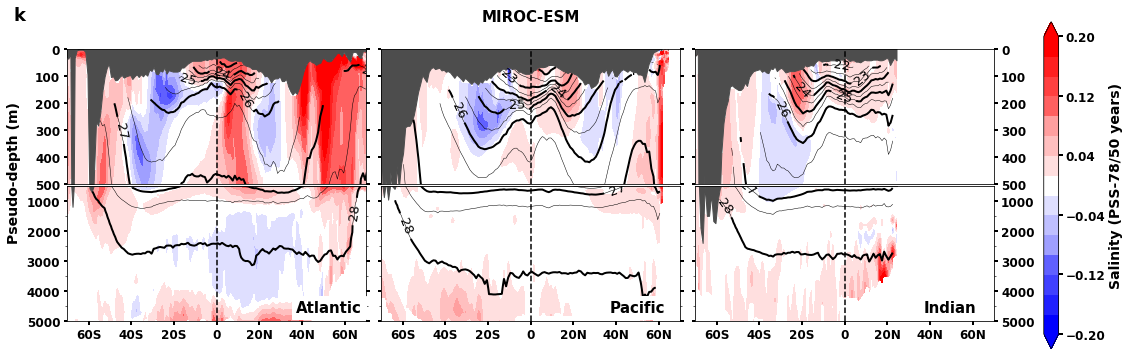

In [16]:
for imod in range(len(model_names)):
# imod=0
    print(model_names[imod])

    # -- Mask points in the bowl 
    for ilat in range(latN):
        if np.isnan(bowl_means[imod,1,ilat]) == False :
            inda = np.ma.nonzero(bowl_means[imod,1,ilat]>=lev)[0]
            trend_means[imod,1,inda,ilat] = np.nan
        if np.isnan(bowl_means[imod,2,ilat]) == False :
            indp = np.ma.nonzero(bowl_means[imod,2,ilat]>=lev)[0]
            trend_means[imod,2,indp,ilat] = np.nan
        if np.isnan(bowl_means[imod,3,ilat]) == False :
            indi = np.ma.nonzero(bowl_means[imod,3,ilat]>=lev)[0]
            trend_means[imod,3,indi,ilat] = np.nan

    # == Remap ==
    # trend_means_z = remaptoz(trend_means.sel(models=model_names[imod]),pseudo_depth,targetz)
    trend_means_z, zbowl_mod = remaptoz_xr(trend_means.sel(models=model_names[imod]),pseudo_depth,targetz)
    
    density_z = density_z.where(xr.DataArray(targetz,dims=['pseudo-depth'],coords=[targetz])>=zbowl_mod)

    # -- Make variable bundles for each basin
    varAtl = {'name': 'Atlantic', 'var_change': trend_means_z[1,:,:], 'bowl1': None, 'bowl2': None,
              'labBowl': None, 'density':density_z[1,:,:]}
    varPac = {'name': 'Pacific', 'var_change': trend_means_z[2,:,:], 'bowl1': None, 'bowl2': None,
              'labBowl': None, 'density':density_z[2,:,:]}
    varInd = {'name': 'Indian', 'var_change': trend_means_z[3,:,:], 'bowl1': None, 'bowl2': None,
              'labBowl': None, 'density':density_z[3,:,:]}

    domzed = [0,500,5000]

    # -- Create figure and axes instances
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

    # -- color map
    cmap = custom_div_cmap()

    # -- levels
    levels = np.linspace(minmax[0],minmax[1],minmax[2])

    ext_cmap = 'both'
    contourDict = {'cmap':cmap, 'levels':levels, 'levels2':levels, 'ext_cmap':ext_cmap, 'isopyc':show_isopyc}

    # -- Contourf of signal
    cnplot = zon_2Dz(plt, axes[0,0], axes[1,0], 'left', lat, targetz, varAtl,
                     contourDict, domzed)
    cnplot = zon_2Dz(plt, axes[0,1], axes[1,1], 'mid', lat, targetz, varPac,
                     contourDict, domzed)
    cnplot = zon_2Dz(plt, axes[0,2], axes[1,2], 'right', lat, targetz, varInd,
                     contourDict, domzed)

    for i in range(3):
    #     # -- Fill upper ocean
        axes[0,i].fill_between(lat,y1=0,y2=zbowl_mod[i+1],color='0.3')
        axes[1,i].fill_between(lat,y1=500,y2=zbowl_mod[i+1],color='0.3')
    #     axes[0,i].plot(lat,zbowl_mod[i+1],color='purple',lw=2)
    #     axes[1,i].plot(lat,zbowl_mod[i+1],color='purple',lw=2)

    plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.05, right=0.86)

    for ax in axes.ravel().tolist():
        ax.tick_params(axis='both', which='major', labelsize=12)

    # -- Add colorbar
    cb = plt.colorbar(cnplot[0], ax=axes.ravel().tolist(), ticks=levels[::3], fraction=0.015, shrink=2.0, pad=0.05)
    cb.set_label('%s (%s/50 years)' % (legVar, unit), fontweight='bold',fontsize=14)
    cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontweight='bold', fontsize=12)
    cb.ax.yaxis.set_tick_params(which='major',width=2,labelsize=12)

    plt.figtext(.006,.96,letters[imod],fontweight='bold',fontsize=18)
    plt.figtext(.001,.35,'Pseudo-depth (m)',rotation='vertical',fontweight='bold',fontsize=14)

    plotTitle = model_names[imod] #+' 1950-2008 trend per 50 years'
    axes[0,1].set_title(plotTitle, y=1.25, fontweight='bold', fontsize=15, verticalalignment='top')

    plt.savefig('suppfig_'+model_names[imod]+'.png', bbox_inches='tight',dpi=150) 